# Data Pre-processing

In [4]:
import re
import csv
import json
import requests
import numpy as np
import csv as csvfile
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline

In [5]:
#This was run on actual data of size ~400MB (~66k tweets) saved in project_data.txt after data collection
# The processed output of this notebook is the actual experiment_data used for this project
'''
f= open('project_data.txt','r')
y = json.load(f)
f.close()'''

# To validate pre-processing start with below code
df= open('demo_tweets.txt','r')
dy = json.load(df)
df.close()

In [6]:
demo_tweets = dy['cancer tweets']

In [7]:
len(demo_tweets)

15000

In [8]:
#Identify unique tweets
unique_tweets =set()
for t in demo_tweets:
    if t['text'] not in unique_tweets:
        t['unique'] = True
        unique_tweets.add(t['text'])
    else:
        t['unique'] = False
print len(unique_tweets)
unique_tweets = None

8240


In [9]:
u= [t for t in demo_tweets if t['unique']]
print len(u)

8240


In [10]:
#Filter non english tweets
english_tweets = [t for t in u if t['lang'] in 'en']
len(english_tweets)

7854

In [11]:
#Read manually labelled tweets for relevant and irrelevant tweets and build the label vector
with open('gender_labels.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    labels=[]
    for row in reader:
        labels.append(str(row['label']))
int_labels = map(int,labels)
int_labels[:10]
y_labels= np.array(int_labels)

In [12]:
print 'label counts=', Counter(y_labels)

label counts= Counter({1: 385, 0: 115})


In [13]:
# Read labelled tweets corresponding to manually labelled data
lab_file = open('labelled_data.txt','r')
lab_tweets = json.load(lab_file)
lab_tw_texts = [t['text'] for t in lab_tweets['cancer tweets']]

In [14]:
# build vectorizer 
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lab_tw_texts)
print 'vectorized %d tweets. found %d terms.' % (X.shape[0], X.shape[1])

vectorized 500 tweets. found 2478 terms.


In [15]:
# cross validation
def do_cv(X, y, nfolds=5):
    cv = KFold(len(y), nfolds, random_state=123456)
    preds = []
    truths = []
    for train, test in cv:
        clf = LogisticRegression(class_weight='auto')
        clf.fit(X[train], y[train])
        preds.extend(clf.predict(X[test]))
        truths.extend(y[test])
        clf = LogisticRegression(class_weight='auto')
        clf.fit(X, y)
    print ('accuracy=%.3f' % (accuracy_score(truths, preds)))
    return clf
clf_train = do_cv(X,y_labels,5)

accuracy=0.850


In [16]:
X_raw = vectorizer.transform(t['text'] for t in english_tweets)
X_raw.shape

(7854, 2478)

In [17]:
predicted_raw = clf_train.predict(X_raw)

In [18]:
print('predicted label distribution on raw tweets: %s' % Counter(predicted_raw))

predicted label distribution on raw tweets: Counter({1: 5929, 0: 1925})


In [19]:
#Collect the relevant tweets
relevant_tweets = []
for t in range(len(english_tweets)):
    if predicted_raw[t]==1:
        english_tweets[t]['label'] = 1
        relevant_tweets.append(english_tweets[t])
    else:
        english_tweets[t]['label'] = 0
        
print len(relevant_tweets)

5929


In [20]:
#Select tweets with non empty location fields
nonblank_locations =[]
for t in (relevant_tweets):
    if t['user']['location'] not in "":
        nonblank_locations.append(t)
print len(nonblank_locations)

3643


In [21]:
# Read list of US cities
with open('ListOfUSCities.txt') as csvfile:
    c_reader = csv.reader(csvfile)
    states=[]
    for row in c_reader:
        states.extend(row)
unique_loc = np.unique(states)
len(unique_loc)
print unique_loc[:10]

['AARONSBURG' 'ABBEVILLE' 'ABBOT' 'ABBOTSFORD' 'ABBOTT' 'ABBOTTSTOWN'
 'ABBYVILLE' 'ABELL' 'ABERCROMBIE' 'ABERDEEN']


In [22]:
low= [x.lower() for x in unique_loc]

In [23]:
# Select tweeets that belong US region
US_tweets=[]
for t in nonblank_locations:
    loc_tokens = (t['user']['location']).lower().split()
    for l in loc_tokens:
        if l in low:
            US_tweets.append(t)
            break
print len(US_tweets)

2501


In [24]:
#Store these tweets for experiments of demographic analysis
outf = open('ProcessedData.txt', 'w')
json.dump({'US_tweets':US_tweets},outf,indent=2)

# Experiments and Analysis

Assume above data(ProcessedData.txt) was stored in US_tweets.txt in actual setup which we will now use here for further processing

In [25]:
# load preprocessed tweets
f= open('US_tweets.txt','r')
x = json.load(f)
f.close()

In [26]:
US_tweets = x['UStweets']

In [27]:
print len(US_tweets)

14510


In [28]:
#Gender lists from US census names
def get_gender():
    males_url = 'http://www2.census.gov/topics/genealogy/1990surnames/dist.male.first'
    females_url = 'http://www2.census.gov/topics/genealogy/1990surnames/dist.female.first'
    males = set([l.split()[0].lower() for l in requests.get(males_url).text.split('\n') if l and float(l.split()[2])])
    females = set([l.split()[0].lower() for l in requests.get(females_url).text.split('\n') if l and float(l.split()[2])])
    print('found %d male and %d female names' % (len(males), len(females)))
    return remove_ambiguous(males, females)

def remove_ambiguous(male_names, female_names):
    ambiguous = male_names & female_names
    male_names -= ambiguous
    female_names -= ambiguous
    print('removed %d ambiguous names now we have %d males and %d females' % (len(ambiguous), len(male_names), len(female_names)))
    return male_names, female_names
    
male_names, female_names = get_gender()

found 1219 male and 4275 female names
removed 331 ambiguous names now we have 888 males and 3944 females


In [29]:
# Label gender based on US census data as (-1:unknown, 0:male , 1:female)
def get_gender(tweet, male_names, female_names):
    name = t['user']['name'].split()[0].lower()
    if name in female_names:
        return 1
    elif name in male_names:
        return 0
    else:
        return -1

In [30]:
#Training Set
gender_train = US_tweets[:200]

In [31]:
# Identify genders for training set
y_gender = np.array([get_gender(t, male_names, female_names) for t in gender_train])
print 'gender labels:', Counter(y_gender).items()

gender labels: [(0, 19), (1, 39), (-1, 142)]


In [32]:
# We will use description and text for tokenization, for that we use these two as one string
def make_strings(tweet_list):
    text_desc = [(t['user']['description'],t['text']) for t in tweet_list]
    user_profiles=[]
    for td in text_desc:
        user_profiles.append(td[0]+td[1])
    return user_profiles

In [33]:
# Tokenizer for text and description strings 
def tokenizer(string, lowercase, keep_punctuation,
             collapse_urls, collapse_mentions):
    if not string:
        return []
    if lowercase:
        string = string.lower()
    tokens = []
    if collapse_urls:
        string = re.sub('http\S+', 'URL', string)
    if collapse_mentions:
        string = re.sub('@\S+', 'MENTION', string)
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
    return tokens

In [34]:
def stringtokens(tweet,lowercase=True,
                 keep_punctuation=True,
                 collapse_urls=True, collapse_mentions=True):
    tokens = tokenizer(tweet, lowercase, keep_punctuation,collapse_urls, collapse_mentions)
    return tokens

In [35]:
def do_cv(X, y, nfolds=5):
    cv = KFold(len(y), nfolds, random_state=123456)
    preds = []
    truths = []
    for train, test in cv:
        clf = LogisticRegression(class_weight='auto')
        clf.fit(X[train], y[train])
        preds.extend(clf.predict(X[test]))
        truths.extend(y[test])
        clf = LogisticRegression(class_weight='auto')
        clf.fit(X, y)
    print ('accuracy=%.3f' % (accuracy_score(truths, preds)))
    return clf

# Gender Analysis

Method 1a:

In [36]:
train_profiles = make_strings(gender_train)

In [37]:
vec = CountVectorizer(tokenizer = stringtokens,min_df=1,
             max_df=1., binary=True, ngram_range=(1,2))
X1 = vec.fit_transform(train_profiles)
X1.shape

(200, 7066)

In [38]:
clf_gender = do_cv(X1,y_gender,5)

accuracy=0.715


In [39]:
test_profiles = make_strings(US_tweets)

In [40]:
X_gen = vec.transform(test_profiles)
X_gen.shape

(14510, 7066)

In [41]:
predicted = clf_gender.predict(X_gen)
print('predicted label distribution on raw tweets: %s' % Counter(predicted))

predicted label distribution on raw tweets: Counter({-1: 14255, 1: 213, 0: 42})


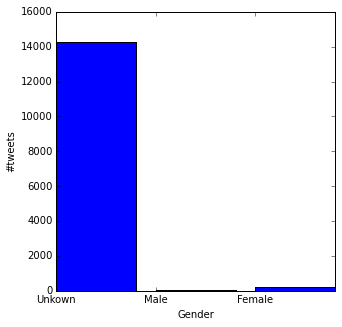

In [42]:
#plotting gender count with 3 categories
g_dict = dict(Counter(predicted))
N= range(3)
g_list = sorted(g_dict.items(), key=lambda s: s[0])
GENDER_vals= [e[1] for e in g_list]
GENDER_labels = ['Unkown','Male','Female'] #(respective values for -1,0,1)
plt.figure(figsize=(5,5))
plt.xticks(N,GENDER_labels)
plt.bar(N,GENDER_vals)
plt.xlabel('Gender')
plt.ylabel('#tweets')
plt.show()

[(-1, 14255), (0, 42), (1, 213)]
[0.9824259131633356, 0.0028945554789800137, 0.014679531357684355]


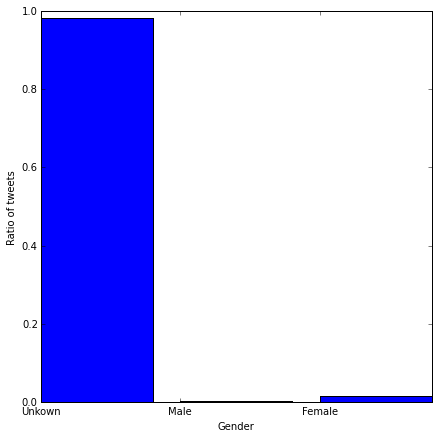

In [71]:
#Plotting gender ratio
g_dict = dict(Counter(predicted))
N= range(3)
g_list = sorted(g_dict.items(), key=lambda s: s[0])
print g_list
GENDER_vals= [e[1] for e in g_list]
ratio=[0,0,0]
G_sum = sum(GENDER_vals)
for v in range(len(GENDER_vals)):
    GENDER_vals[v] = 1.*GENDER_vals[v]/G_sum
print GENDER_vals
GENDER_labels = ['Unkown','Male','Female'] #(respective values for -1,0,1)
plt.figure(figsize=(7,7))
plt.xticks(N,GENDER_labels)
plt.bar(N,GENDER_vals)
plt.xlabel('Gender')
plt.ylabel('Ratio of tweets')
plt.savefig('Exp1_gender_analysis.pdf', bbox_inches='tight')
plt.show()

Method 1b:

In [44]:
y_gender_2 = np.array([get_gender(t, male_names, female_names) for t in US_tweets])
print 'gender labels:', Counter(y_gender_2).items()

gender labels: [(0, 1965), (1, 2637), (-1, 9908)]


In [45]:
vec2 = CountVectorizer(tokenizer = stringtokens,min_df=1,
             max_df=1., binary=True, ngram_range=(1,2))
X_gen2 = vec2.fit_transform(test_profiles)
X_gen2.shape

(14510, 189687)

In [46]:
#Training whole and testing accuracy on whole
clf_gender2 = do_cv(X_gen2,y_gender_2,5)

accuracy=0.825


In [47]:
predicted_raw2 = clf_gender2.predict(X_gen2)
print('predicted label distribution on raw tweets: %s' % Counter(predicted_raw2))

predicted label distribution on raw tweets: Counter({-1: 9915, 1: 2639, 0: 1956})


[(-1, 9915), (0, 1956), (1, 2639)]


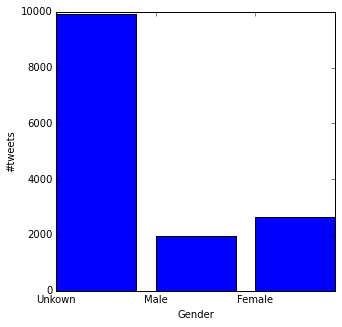

In [48]:
#Plotting gender count with 3 categories
g_dict2 = dict(Counter(predicted_raw2))
N= range(3)
g_list2 = sorted(g_dict2.items(), key=lambda s: s[0])
print g_list2
GENDER_vals2 = [e[1] for e in g_list2]
GENDER_labels2 = ['Unkown','Male','Female'] #(respective values for -1,0,1)
plt.figure(figsize=(5,5))
plt.xticks(N,GENDER_labels2)
plt.bar(N,GENDER_vals2)
plt.xlabel('Gender')
plt.ylabel('#tweets')
plt.show()

[(-1, 9915), (0, 1956), (1, 2639)]
[0.6833218470020676, 0.13480358373535492, 0.18187456926257753]


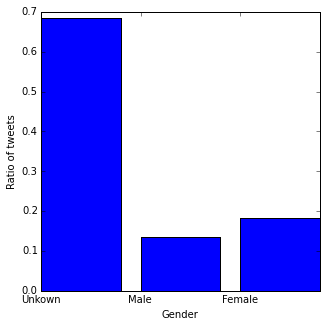

In [70]:
#Plotting gender ratio
g_dict2 = dict(Counter(predicted_raw2))
N= range(3)
g_list2 = sorted(g_dict2.items(), key=lambda s: s[0])
print g_list2
GENDER_vals2 = [e[1] for e in g_list2]
ratio=[0,0,0]
G_sum = sum(GENDER_vals2)
for v in range(len(GENDER_vals2)):
    GENDER_vals2[v] = 1.*GENDER_vals2[v]/G_sum
print GENDER_vals2
GENDER_labels2 = ['Unkown','Male','Female'] #(respective values for -1,0,1)
plt.figure(figsize=(5,5))
plt.xticks(N,GENDER_labels2)
plt.bar(N,GENDER_vals2)
plt.xlabel('Gender')
plt.ylabel('Ratio of tweets')
plt.savefig('Exp2_gender_analysis.pdf', bbox_inches='tight')
plt.show()

#Method 2

In [50]:
#Read manual labelled data
import sys
with open('US_label_gender.csv','r') as csvfile:
    reader = csv.DictReader(csvfile)
    g_labels=[]
    for row in reader:
        g_labels.append((row['gender']))
y_gender3 =np.array(g_labels)
len(y_gender3)

200

In [51]:
vec3 = CountVectorizer(tokenizer = stringtokens,min_df=1,
             max_df=1., binary=True, ngram_range=(1,2))
X_gen3 = vec3.fit_transform(train_profiles)

In [52]:
clf_gender3 = do_cv(X_gen3,y_gender3,5)

accuracy=0.435


In [53]:
X_gen3 = vec3.transform(test_profiles)
X_gen3.shape

(14510, 7066)

In [54]:
predicted_raw3 = clf_gender3.predict(X_gen3)
print('predicted label distribution on raw tweets: %s' % Counter(predicted_raw3))

predicted label distribution on raw tweets: Counter({'2': 7511, '1': 4515, '0': 1644, '-1': 840})


[('-1', 840), ('0', 1644), ('1', 4515), ('2', 7511)]


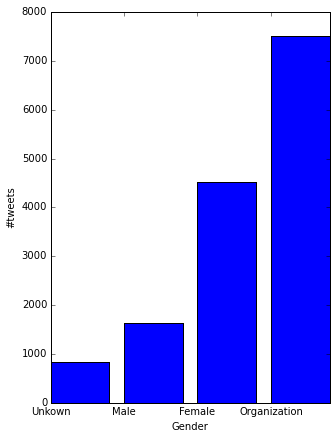

In [55]:
#Plotting gender count with 4 categories
g_dict3 = dict(Counter(predicted_raw3))
N= range(4)
g_list3 = sorted(g_dict3.items(), key=lambda s: s[0])
print g_list3
GENDER_vals3 = [e[1] for e in g_list3]
GENDER_labels3 = ['Unkown','Male','Female','Organization'] #(respective values for -1,0,1)
plt.figure(figsize=(5,7))
plt.xticks(N,GENDER_labels3)
plt.bar(N,GENDER_vals3)
plt.xlabel('Gender')
plt.ylabel('#tweets')
plt.show()

[('-1', 840), ('0', 1644), ('1', 4515), ('2', 7511)]
[0.057891109579600274, 0.1133011716057891, 0.3111647139903515, 0.5176430048242592]


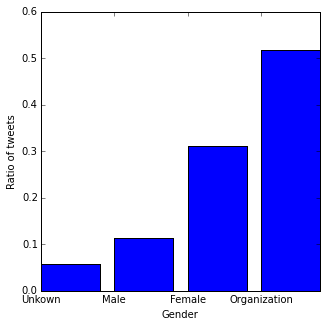

In [69]:
#Plotting gender ratio
g_dict3 = dict(Counter(predicted_raw3))
N= range(4)
g_list3 = sorted(g_dict3.items(), key=lambda s: s[0])
print g_list3
GENDER_vals3 = [e[1] for e in g_list3]
ratio=[0,0,0]
G_sum = sum(GENDER_vals3)
for v in range(len(GENDER_vals3)):
    GENDER_vals3[v] = 1.*GENDER_vals3[v]/G_sum
print GENDER_vals3
GENDER_labels3 = ['Unkown','Male','Female','Organization'] #(respective values for -1,0,1)
plt.figure(figsize=(5,5))
plt.xticks(N,GENDER_labels3)
plt.bar(N,GENDER_vals3)
plt.xlabel('Gender')
plt.ylabel('Ratio of tweets')
plt.savefig('Exp3_gender_analysis.pdf', bbox_inches='tight')
plt.show()

# Location Analysis

In [57]:
with open('ListOfUSCities.txt', 'r') as txtfile:
    read = csv.reader(txtfile, delimiter=',')
    locs = [t['user']['location'] for t in US_tweets]

In [62]:
def get_location_tokens(location):
    location_tokens = []
    if len(location) > 0:
        location_tokens.extend(location.split(","))
    return location_tokens

In [63]:
#Below function identifies the States for users by searching in USCities list.
#This is an expensive function, expect delays in processing(~25mins)

In [59]:
with open('ListOfUSCities.txt', 'r') as txtfile:
    read = csv.reader(txtfile, delimiter=',')
    locations = [(t['user']['location']).lower() for t in US_tweets]
    #print locations
    #templocs = [t.lower() for t in locs]
    states =[]
    for t in locations:
        i = get_location_tokens(t)
        statefound = False
        for li in i:            
            with open('ListOfUSCities.txt', 'r') as txtfile:
                read = csv.reader(txtfile, delimiter=',')
                for row in read:
                    row = [r.lower() for r in row]
                    #print row
                    
                    if li in row:
                        statefound= True
                        states.append(row[1])
                        break
                    else:
                        statefound = False
            if statefound:
                break
                    
states = [s.upper() for s in states]
print len(states)

9685


In [64]:
y = Counter(states)
dict_y = dict(Counter(states))

In [65]:
awareness_by_loc = sorted(dict_y.items(), key=lambda s: s[1])
print '10 least aware states in the US:\n',awareness_by_loc[:10]

10 least aware states in the US:
[('VT', 2), ('DC', 4), ('PR', 5), ('WY', 6), ('RI', 6), ('DE', 7), ('WV', 7), ('NH', 8), ('SD', 10), ('TN', 11)]


In [66]:
y_list = sorted(dict_y.items(), key=lambda s: s[0])
vals= [e[1] for e in y_list]

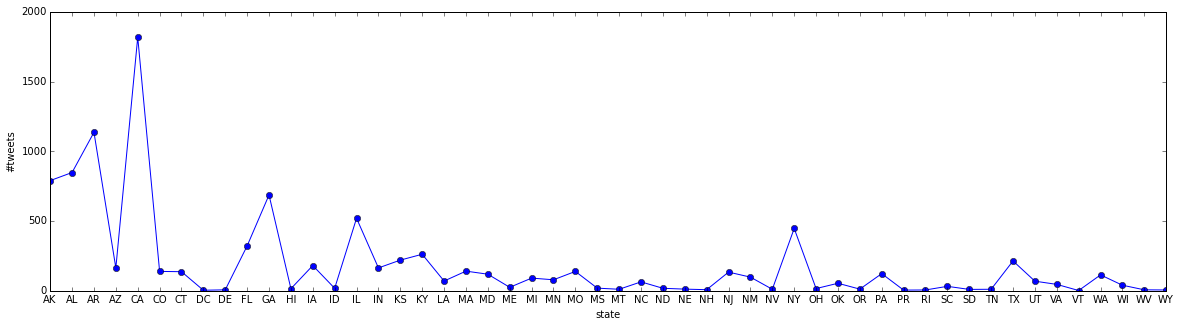

In [67]:
#Plotting awareness count by State
N = range(52)
state_labels = [k[0] for k in y_list]
state_vals= [e[1] for e in y_list]
plt.figure(figsize=(20,5))
plt.xticks(N,state_labels)
plt.plot(N,state_vals,'-bo')
plt.xlabel('state')
plt.ylabel('#tweets')
plt.show()

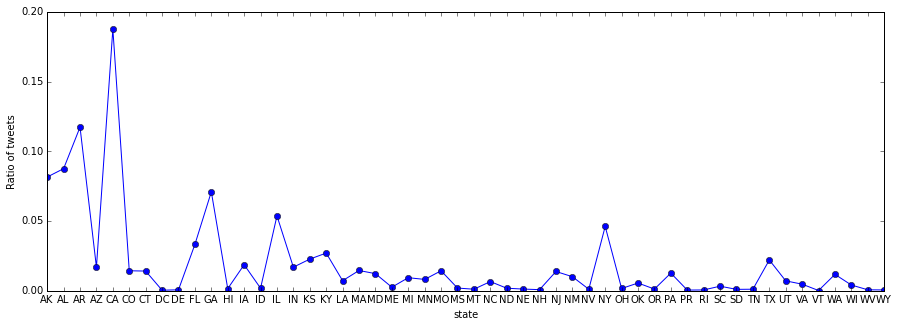

In [72]:
#Plotting awareness ratio by State
N = range(52)
state_labels = [k[0] for k in y_list]
state_vals= [e[1] for e in y_list]
s_sum = sum(state_vals)
for v in range(len(state_vals)):
    state_vals[v] = 1.*state_vals[v]/s_sum
plt.figure(figsize=(15,5))
plt.xticks(N,state_labels)
plt.plot(N,state_vals,'-bo')
plt.xlabel('state')
plt.ylabel('Ratio of tweets')
plt.savefig('location_analysis.pdf', bbox_inches='tight')
plt.show() 